In [1]:
#%matplotlib notebook
import os
import matplotlib.pyplot as plt
import numpy as np
import lal
import lalsimulation as lalsim
import sys
sys.path.append('../scripts')
import compute_sigmalm0_SimIMREOBGenerateQNMFreqV2 as calcqnm
import scipy
import scipy.signal as ss
from scipy import interpolate
import scipy.ndimage.filters as filter
from optparse import OptionParser
import corner

In [2]:
# Module for confidence calculations
class confidence(object):
    def __init__(self, counts):
        # Sort in descending order in frequency
        self.counts_sorted = np.sort(counts.flatten())[::-1]
        # Get a normalized cumulative distribution from the mode
        self.norm_cumsum_counts_sorted = np.cumsum(self.counts_sorted) / np.sum(counts)
        # Set interpolations between heights, bins and levels
        self._set_interp()
    def _set_interp(self):
        self._length = len(self.counts_sorted)
        # height from index
        self._height_from_idx = interpolate.interp1d(np.arange(self._length), self.counts_sorted, bounds_error=False, fill_value=0.)
        # index from height
        self._idx_from_height = interpolate.interp1d(self.counts_sorted[::-1], np.arange(self._length)[::-1], bounds_error=False, fill_value=self._length)
        # level from index
        self._level_from_idx = interpolate.interp1d(np.arange(self._length), self.norm_cumsum_counts_sorted, bounds_error=False, fill_value=1.)
        # index from level
        self._idx_from_level = interpolate.interp1d(self.norm_cumsum_counts_sorted, np.arange(self._length), bounds_error=False, fill_value=self._length)
    def level_from_height(self, height):
        return self._level_from_idx(self._idx_from_height(height))
    def height_from_level(self, level):
        return self._height_from_idx(self._idx_from_level(level))

# gaussian filter of histogram
def gf(P):
    return filter.gaussian_filter(P, sigma=1.0)


# 
def P_xy_2dhist(x, y, N_bins):
    x_bins = np.linspace(min(x), max(x), N_bins)
    y_bins = np.linspace(min(y), max(y), N_bins)

    dx = np.mean(np.diff(x_bins))
    dy = np.mean(np.diff(y_bins))

    x_intp = (x_bins[:-1] + x_bins[1:])/2.
    y_intp = (y_bins[:-1] + y_bins[1:])/2.
    
    P_xy, x_bins, y_bins = np.histogram2d(x, y, bins=(x_bins, y_bins), normed=True)
    P_xy = P_xy.T
    
    conf = confidence(P_xy)
    s1 = conf.height_from_level(0.5)
    s2 = conf.height_from_level(0.9)
    
    return P_xy, x_intp, y_intp, s1, s2

# GW150914

## Real data

In [3]:
seob_loc = '../runs/XLALSimInspiralChooseTDWaveformFromCache_runs/ligo_events/GW150914/220/cbcBayes/posterior_samples.dat'
data = np.genfromtxt(seob_loc, names=True, dtype=None)
m1, m2, a1z, a2z, domega, dtau = data['m1'], data['m2'], data['a1z'], data['a2z'], data['domega220'], data['dtau220']
lm = [2,2]

# create (omega, tau) GR and modGRarrays
omega_GR, tau_GR = calcqnm.get_sigmalm0SI_GR(m1, m2, a1z, a2z, lm)
freq_GR = omega_GR/(2.*np.pi)

omega_modGR, tau_modGR = calcqnm.get_sigmalm0SI_modGR(omega_GR, tau_GR, domega, dtau)
freq_modGR = omega_modGR/(2.*np.pi)

f_seob = freq_modGR
tau_seob = tau_modGR
samples_seob = np.vstack((f_seob, tau_seob)).T

In [4]:
seob_loc_gr = '../runs/XLALSimInspiralChooseTDWaveformFromCache_runs/ligo_events/GW150914/GR/cbcBayes/posterior_samples.dat'
data = np.genfromtxt(seob_loc_gr, names=True, dtype=None)
m1, m2, a1z, a2z = data['m1'], data['m2'], data['a1z'], data['a2z']
lm = [2,2]

# create (omega, tau) GR and modGRarrays
omega_GR, tau_GR = calcqnm.get_sigmalm0SI_GR(m1, m2, a1z, a2z, lm)
freq_GR = omega_GR/(2.*np.pi)

f_seob_gr = freq_GR
tau_seob_gr = tau_GR
samples_seob_gr = np.vstack((f_seob_gr, tau_seob_gr)).T

In [5]:
eob_loc = '../data/GW150914/pEOBNRv2HM_frac_richard_220.dat'
data = np.genfromtxt(eob_loc, names=True, dtype=None)
m1, m2, domega, dtau = data['m1'], data['m2'], data['domega220'], data['dtau220']
a1z, a2z = np.zeros(len(m1)), np.zeros(len(m2))

lm = [2,2]

# create (omega, tau) GR and modGRarrays
omega_GR, tau_GR = calcqnm.get_sigmalm0SI_GR(m1, m2, a1z, a2z, lm)
freq_GR = omega_GR/(2.*np.pi)

omega_modGR, tau_modGR = calcqnm.get_sigmalm0SI_modGR(omega_GR, tau_GR, domega, dtau)
freq_modGR = omega_modGR/(2.*np.pi)

f_eob = freq_modGR
tau_eob = tau_modGR
samples_eob = np.vstack((f_eob, tau_eob)).T

### Testing GR QNM analysis

In [6]:
f_eob_gr, tau_eob_gr = np.loadtxt('../data/GW150914/Fig2/pEOB.dat', unpack=True)
samples_eob_gr = np.vstack((f_eob_gr, tau_eob_gr)).T

f_imr, tau_imr = np.loadtxt('../data/GW150914/Fig2/QNM_IMR.dat', unpack=True)
samples_imr = np.vstack((f_imr, tau_imr)).T

In [7]:
td_loc = '../data/GW150914/gregorio_220.dat'
data = np.genfromtxt(td_loc, names=True, dtype=None)

f_td = data['f0']
tau_td = data['tau0']
samples_td = np.vstack((f_td, tau_td)).T

/home/abhirup.ghosh/.local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(210, 290)

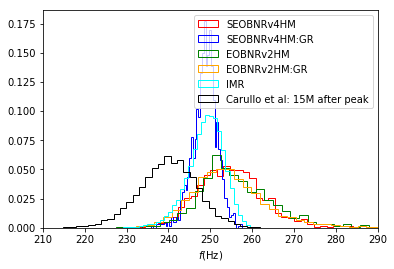

In [8]:
plt.figure()
plt.hist(f_seob, bins=50, histtype='step', label='SEOBNRv4HM', normed=True, color='r')
plt.hist(f_seob_gr, bins=50, histtype='step', label='SEOBNRv4HM:GR', normed=True, color='b')
plt.hist(f_eob, bins=50, histtype='step', label='EOBNRv2HM', normed=True, color='g')
plt.hist(f_eob_gr, bins=50, histtype='step', label='EOBNRv2HM:GR', normed=True, color='orange')
plt.hist(f_imr, bins=50, histtype='step', label='IMR', normed=True, color='cyan')
plt.hist(f_td, bins=50, histtype='step', label='Carullo et al: 15M after peak', normed=True, color='k')
plt.xlabel("$f$(Hz)")
plt.legend(loc='best')
plt.xlim([210,290])

(0.002, 0.008)

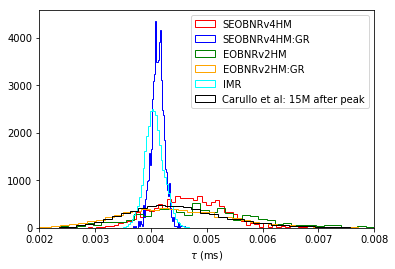

In [9]:
plt.figure()
plt.hist(tau_seob, bins=50, histtype='step', label='SEOBNRv4HM', normed=True, color='r')
plt.hist(tau_seob_gr, bins=50, histtype='step', label='SEOBNRv4HM:GR', normed=True, color='b')
plt.hist(tau_eob, bins=50, histtype='step', label='EOBNRv2HM', normed=True, color='g')
plt.hist(tau_eob_gr/1000., bins=50, histtype='step', label='EOBNRv2HM:GR', normed=True, color='orange')
plt.hist(tau_imr/1000., bins=50, histtype='step', label='IMR', normed=True, color='cyan')
plt.hist(tau_td, bins=50, histtype='step', label='Carullo et al: 15M after peak', normed=True, color='k')
plt.xlabel(r"$\tau$ (ms)")
plt.legend(loc='best')
plt.xlim([0.002, 0.008])

/home/abhirup.ghosh/.local/lib/python2.7/site-packages/matplotlib/contour.py:1004: UserWarning: The following kwargs were not used by contour: 'labels'
  s)
/.auto/home/abhirup.ghosh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  """
/home/abhirup.ghosh/.local/lib/python2.7/site-packages/matplotlib/__init__.py:910: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/home/abhirup.ghosh/.local/lib/python2.7/site-packages/matplotlib/rcsetup.py:156: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)
/.auto/home/abhirup.ghosh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Futu

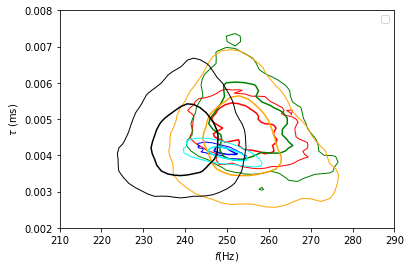

In [10]:
plt.figure()

P_xy, x_intp, y_intp, s1, s2 = P_xy_2dhist(f_seob, tau_seob, 50)
plt.contour(x_intp,y_intp,gf(P_xy), levels=(s2,s1), linewidths=(1,1.5), colors='r', labels='SEOBNRv4HM')
plt.hold(True)

P_xy, x_intp, y_intp, s1, s2 = P_xy_2dhist(f_seob_gr, tau_seob_gr, 50)
plt.contour(x_intp,y_intp,gf(P_xy), levels=(s2,s1), linewidths=(1,1.5), colors='b', labels='SEOBNRv4HM:GR')
plt.hold(True)

P_xy, x_intp, y_intp, s1, s2 = P_xy_2dhist(f_eob, tau_eob, 50)
plt.contour(x_intp,y_intp,gf(P_xy), levels=(s2,s1), linewidths=(1,1.5), colors='g', labels='EOBNRv2HM')
plt.hold(True)

P_xy, x_intp, y_intp, s1, s2 = P_xy_2dhist(f_eob_gr, tau_eob_gr/1000., 50)
plt.contour(x_intp,y_intp,gf(P_xy), levels=(s2,s1), linewidths=(1,1.5), colors='orange', labels='EOBNRv2HM:GR')
plt.hold(True)

P_xy, x_intp, y_intp, s1, s2 = P_xy_2dhist(f_imr, tau_imr/1000., 50)
plt.contour(x_intp,y_intp,gf(P_xy), levels=(s2,s1), linewidths=(1,1.5), colors='cyan', labels='IMR')
plt.hold(True)

P_xy, x_intp, y_intp, s1, s2 = P_xy_2dhist(f_td, tau_td, 50)
plt.contour(x_intp,y_intp,gf(P_xy), levels=(s2,s1), linewidths=(1,1.5), colors='k', labels='Carullo et al: 15M after peak')
plt.legend(loc='best')
plt.xlabel("$f$(Hz)")
plt.ylabel(r"$\tau$ (ms)")
plt.xlim([210,290])
plt.ylim([0.002, 0.008])
plt.show()

## Software Injection

In [11]:
seob_loc = '../data/GW150914/SXS_007_pSEOBNR.dat'
data = np.genfromtxt(seob_loc, names=True, dtype=None)
m1, m2, a1z, a2z, domega, dtau = data['m1'], data['m2'], data['a1z'], data['a2z'], data['domega220'], data['dtau220']
lm = [2,2]

# create (omega, tau) GR and modGRarrays
omega_GR, tau_GR = calcqnm.get_sigmalm0SI_GR(m1, m2, a1z, a2z, lm)
freq_GR = omega_GR/(2.*np.pi)

omega_modGR, tau_modGR = calcqnm.get_sigmalm0SI_modGR(omega_GR, tau_GR, domega, dtau)
freq_modGR = omega_modGR/(2.*np.pi)

f_seob = freq_modGR
tau_seob = tau_modGR
samples_seob = np.vstack((f_seob, tau_seob)).T

In [12]:
eob_loc = '../data/GW150914/SXS_007_pEOBNR.txt'
f_eob, tau_eob = np.loadtxt(eob_loc, unpack=True)
tau_eob = tau_eob/1000.
samples_eob = np.vstack((f_eob, tau_eob)).T

/.auto/home/abhirup.ghosh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  """
/.auto/home/abhirup.ghosh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  if __name__ == '__main__':


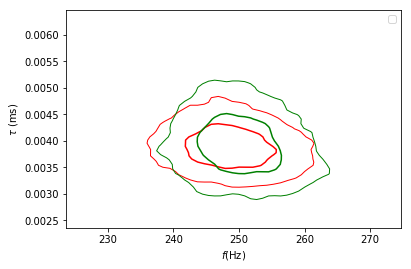

In [13]:
plt.figure()

P_xy, x_intp, y_intp, s1, s2 = P_xy_2dhist(f_seob, tau_seob, 50)
plt.contour(x_intp,y_intp,gf(P_xy), levels=(s2,s1), linewidths=(1,1.5), colors='r', labels='SEOB')
plt.hold(True)

P_xy, x_intp, y_intp, s1, s2 = P_xy_2dhist(f_eob, tau_eob, 50)
plt.contour(x_intp,y_intp,gf(P_xy), levels=(s2,s1), linewidths=(1,1.5), colors='g', labels='EOB')
plt.hold(True)

#P_xy, x_intp, y_intp, s1, s2 = P_xy_2dhist(f_td, tau_td, 50)
#plt.contour(x_intp,y_intp,gf(P_xy), levels=(s2,s1), linewidths=(1,1.5), colors='k', labels='Gregorio')
plt.legend(loc='best')
plt.xlabel("$f$(Hz)")
plt.ylabel(r"$\tau$ (ms)")
plt.show()

# S190521g

## Real data

In [14]:
eob_loc = '../data/S190521g/pEOBNRv2HM_frac_richard_220_c01.dat'
data = np.genfromtxt(eob_loc, names=True, dtype=None)
m1, m2, domega, dtau = data['m1'], data['m2'], data['domega220'], data['dtau220']
a1z, a2z = np.zeros(len(m1)), np.zeros(len(m2))

lm = [2,2]

# create (omega, tau) GR and modGRarrays
omega_GR, tau_GR = calcqnm.get_sigmalm0SI_GR(m1, m2, a1z, a2z, lm)
freq_GR = omega_GR/(2.*np.pi)

omega_modGR, tau_modGR = calcqnm.get_sigmalm0SI_modGR(omega_GR, tau_GR, domega, dtau)
freq_modGR = omega_modGR/(2.*np.pi)

f_eob = freq_modGR
tau_eob = tau_modGR
samples_eob = np.vstack((f_eob, tau_eob)).T

In [15]:
eob_loc_nonsens = '../data/S190521g/pEOBNRv2HM_frac_richard_220_c01_nonsens.dat'
data = np.genfromtxt(eob_loc_nonsens, names=True, dtype=None)
m1, m2, domega, dtau = data['m1'], data['m2'], data['domega220'], data['dtau220']
a1z, a2z = np.zeros(len(m1)), np.zeros(len(m2))

lm = [2,2]

# create (omega, tau) GR and modGRarrays
omega_GR, tau_GR = calcqnm.get_sigmalm0SI_GR(m1, m2, a1z, a2z, lm)
freq_GR = omega_GR/(2.*np.pi)

omega_modGR, tau_modGR = calcqnm.get_sigmalm0SI_modGR(omega_GR, tau_GR, domega, dtau)
freq_modGR = omega_modGR/(2.*np.pi)

f_eob_nonsens = freq_modGR
tau_eob_nonsens = tau_modGR
samples_eob_nonsens = np.vstack((f_eob_nonsens, tau_eob_nonsens)).T

In [16]:
eob_gr_loc = '../data/S190521g/pEOBNRv2HM_frac_richard_GR.dat'
data = np.genfromtxt(eob_gr_loc, names=True, dtype=None)
m1, m2 = data['m1'], data['m2']
a1z, a2z = np.zeros(len(m1)), np.zeros(len(m2))

lm = [2,2]

# create (omega, tau) GR and modGRarrays
omega_GR, tau_GR = calcqnm.get_sigmalm0SI_GR(m1, m2, a1z, a2z, lm)
freq_GR = omega_GR/(2.*np.pi)


f_eob_gr = freq_GR
tau_eob_gr = tau_GR
samples_eob_gr = np.vstack((f_eob_gr, tau_eob_gr)).T

In [17]:
seob_loc = '../runs/XLALSimInspiralChooseTDWaveformFromCache_runs/ligo_events/S190521g/C01/220/cbcBayes/posterior_samples.dat'
data = np.genfromtxt(seob_loc, names=True, dtype=None)
m1, m2, a1z, a2z, domega, dtau = data['m1'], data['m2'], data['a1z'], data['a2z'], data['domega220'], data['dtau220']
lm = [2,2]

# create (omega, tau) GR and modGRarrays
omega_GR, tau_GR = calcqnm.get_sigmalm0SI_GR(m1, m2, a1z, a2z, lm)
freq_GR = omega_GR/(2.*np.pi)

omega_modGR, tau_modGR = calcqnm.get_sigmalm0SI_modGR(omega_GR, tau_GR, domega, dtau)
freq_modGR = omega_modGR/(2.*np.pi)

f_seob = freq_modGR
tau_seob = tau_modGR
samples_seob = np.vstack((f_seob, tau_seob)).T

In [18]:
seob_loc_nonsens = '../runs/XLALSimInspiralChooseTDWaveformFromCache_runs/ligo_events/S190521g/C01_nonsens/220/cbcBayes/posterior_samples.dat'
data = np.genfromtxt(seob_loc_nonsens, names=True, dtype=None)
m1, m2, a1z, a2z, domega, dtau = data['m1'], data['m2'], data['a1z'], data['a2z'], data['domega220'], data['dtau220']
lm = [2,2]

# create (omega, tau) GR and modGRarrays
omega_GR, tau_GR = calcqnm.get_sigmalm0SI_GR(m1, m2, a1z, a2z, lm)
freq_GR = omega_GR/(2.*np.pi)

omega_modGR, tau_modGR = calcqnm.get_sigmalm0SI_modGR(omega_GR, tau_GR, domega, dtau)
freq_modGR = omega_modGR/(2.*np.pi)

f_seob_nonsens = freq_modGR
tau_seob_nonsens = tau_modGR
samples_seob_nonsens = np.vstack((f_seob, tau_seob)).T

In [19]:
seob_loc_gr = '../runs/XLALSimInspiralChooseTDWaveformFromCache_runs/ligo_events/S190521g/C01/GR/cbcBayes/posterior_samples.dat'
data = np.genfromtxt(seob_loc_gr, names=True, dtype=None)
m1, m2, a1z, a2z = data['m1'], data['m2'], data['a1z'], data['a2z']
lm = [2,2]

# create (omega, tau) GR and modGRarrays
omega_GR, tau_GR = calcqnm.get_sigmalm0SI_GR(m1, m2, a1z, a2z, lm)
freq_GR = omega_GR/(2.*np.pi)

f_seob_gr = freq_GR
tau_seob_gr = tau_GR
samples_seob_gr = np.vstack((f_seob_gr, tau_seob_gr)).T

In [20]:
td_loc = '../data/S190521g/gregorio_220.dat'
data = np.genfromtxt(td_loc, names=True, dtype=None)

f_td = data['f0']
tau_td = data['tau0']
samples_td = np.vstack((f_td, tau_td)).T

In [21]:
seob_loc_gr_phm = '../data/S190521g/SEOBNRv4PHM_c00.dat'
data = np.genfromtxt(seob_loc_gr_phm, names=True, dtype=None)
m1, m2, a1z, a2z = data['m1'], data['m2'], data['a1z'], data['a2z']
lm = [2,2]

# create (omega, tau) GR and modGRarrays
omega_GR, tau_GR = calcqnm.get_sigmalm0SI_GR(m1, m2, a1z, a2z, lm)
freq_GR = omega_GR/(2.*np.pi)

f_seob_gr_phm = freq_GR
tau_seob_gr_phm = tau_GR
samples_seob_gr_phm = np.vstack((f_seob_gr_phm, tau_seob_gr_phm)).T

/.auto/home/abhirup.ghosh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  """
/.auto/home/abhirup.ghosh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  if __name__ == '__main__':
/.auto/home/abhirup.ghosh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  del sys.path[0]
/.auto/home/abhirup.ghosh/.local/lib/python2.7/site-packages/ipykernel

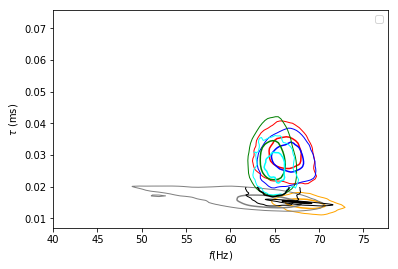

In [22]:
plt.figure()

P_xy, x_intp, y_intp, s1, s2 = P_xy_2dhist(f_seob, tau_seob, 50)
plt.contour(x_intp,y_intp,gf(P_xy), levels=(s2,s1), linewidths=(1,1.5), colors='r', labels='SEOB')
plt.hold(True)

P_xy, x_intp, y_intp, s1, s2 = P_xy_2dhist(f_seob_nonsens, tau_seob_nonsens, 50)
plt.contour(x_intp,y_intp,gf(P_xy), levels=(s2,s1), linewidths=(1,1.5), colors='b', labels='SEOB')
plt.hold(True)

P_xy, x_intp, y_intp, s1, s2 = P_xy_2dhist(f_seob_gr, tau_seob_gr, 50)
plt.contour(x_intp,y_intp,gf(P_xy), levels=(s2,s1), linewidths=(1,1.5), colors='orange', labels='SEOB')
plt.hold(True)

P_xy, x_intp, y_intp, s1, s2 = P_xy_2dhist(f_seob_gr_phm, tau_seob_gr_phm, 50)
plt.contour(x_intp,y_intp,gf(P_xy), levels=(s2,s1), linewidths=(1,1.5), colors='grey', labels='SEOB')
plt.hold(True)

P_xy, x_intp, y_intp, s1, s2 = P_xy_2dhist(f_eob, tau_eob, 50)
plt.contour(x_intp,y_intp,gf(P_xy), levels=(s2,s1), linewidths=(1,1.5), colors='g', labels='EOB')
plt.hold(True)

P_xy, x_intp, y_intp, s1, s2 = P_xy_2dhist(f_eob_nonsens, tau_eob_nonsens, 50)
plt.contour(x_intp,y_intp,gf(P_xy), levels=(s2,s1), linewidths=(1,1.5), colors='cyan', labels='SEOB')
plt.hold(True)

P_xy, x_intp, y_intp, s1, s2 = P_xy_2dhist(f_eob_gr, tau_eob_gr, 50)
plt.contour(x_intp,y_intp,gf(P_xy), levels=(s2,s1), linewidths=(1,1.5), colors='k', labels='EOB')
plt.hold(True)

P_xy, x_intp, y_intp, s1, s2 = P_xy_2dhist(f_td, tau_td, 50)
plt.contour(x_intp,y_intp,gf(P_xy), levels=(s2,s1), linewidths=(1,1.5), colors='k', labels='Gregorio')
plt.legend(loc='best')
plt.xlabel("$f$(Hz)")
plt.ylabel(r"$\tau$ (ms)")
plt.show()

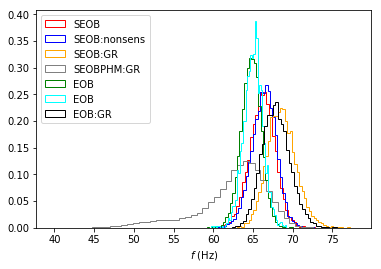

In [23]:
plt.figure()
plt.hist(f_seob, bins=50, histtype='step', label='SEOB', normed=True, color='r')
plt.hist(f_seob_nonsens, bins=50, histtype='step', label='SEOB:nonsens', normed=True, color='b')
plt.hist(f_seob_gr, bins=50, histtype='step', label='SEOB:GR', normed=True, color='orange')
plt.hist(f_seob_gr_phm, bins=50, histtype='step', label='SEOBPHM:GR', normed=True, color='grey')
plt.hist(f_eob, bins=50, histtype='step', label='EOB', normed=True, color='g')
plt.hist(f_eob_nonsens, bins=50, histtype='step', label='EOB', normed=True, color='cyan')
plt.hist(f_eob_gr, bins=50, histtype='step', label='EOB:GR', normed=True, color='k')
plt.xlabel(r"$f$ (Hz)")
plt.legend(loc='best')
plt.show()

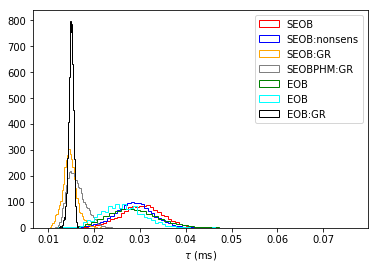

In [24]:
plt.figure()
plt.hist(tau_seob, bins=50, histtype='step', label='SEOB', normed=True, color='r')
plt.hist(tau_seob_nonsens, bins=50, histtype='step', label='SEOB:nonsens', normed=True, color='b')
plt.hist(tau_seob_gr, bins=50, histtype='step', label='SEOB:GR', normed=True, color='orange')
plt.hist(tau_seob_gr_phm, bins=50, histtype='step', label='SEOBPHM:GR', normed=True, color='grey')
plt.hist(tau_eob, bins=50, histtype='step', label='EOB', normed=True, color='g')
plt.hist(tau_eob_nonsens, bins=50, histtype='step', label='EOB', normed=True, color='cyan')
plt.hist(tau_eob_gr, bins=50, histtype='step', label='EOB:GR', normed=True, color='k')
plt.xlabel(r"$\tau$ (ms)")
plt.legend(loc='best')
plt.show()

## EOB Results

/.auto/home/abhirup.ghosh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  after removing the cwd from sys.path.
/.auto/home/abhirup.ghosh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  
/.auto/home/abhirup.ghosh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  if sys.path[0] == '':


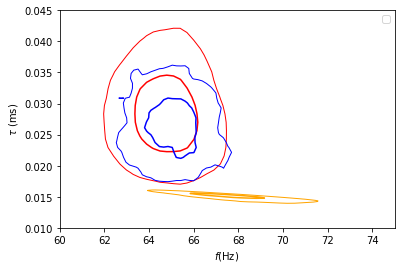

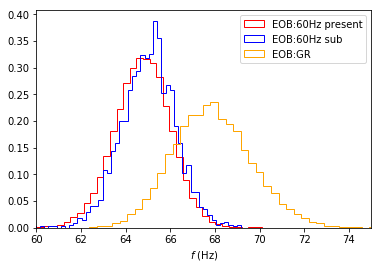

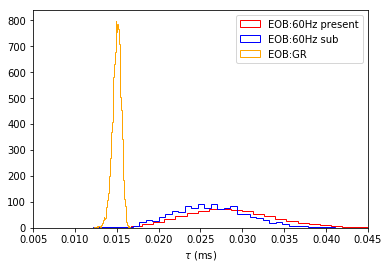

In [25]:
plt.figure()
P_xy, x_intp, y_intp, s1, s2 = P_xy_2dhist(f_eob, tau_eob, 50)
plt.contour(x_intp,y_intp,gf(P_xy), levels=(s2,s1), linewidths=(1,1.5), colors='r', labels='EOB:60Hz present')
plt.hold(True)

P_xy, x_intp, y_intp, s1, s2 = P_xy_2dhist(f_eob_nonsens, tau_eob_nonsens, 50)
plt.contour(x_intp,y_intp,gf(P_xy), levels=(s2,s1), linewidths=(1,1.5), colors='b', labels='EOB:60Hz sub')
plt.hold(True)

P_xy, x_intp, y_intp, s1, s2 = P_xy_2dhist(f_eob_gr, tau_eob_gr, 50)
plt.contour(x_intp,y_intp,gf(P_xy), levels=(s2,s1), linewidths=(1,1.5), colors='orange', labels='EOB:GR')
plt.hold(True)

plt.legend(loc='best')
plt.xlabel("$f$(Hz)")
plt.ylabel(r"$\tau$ (ms)")
plt.xlim([60,75])
plt.ylim([0.01,0.045])
plt.show()

plt.figure()
plt.hist(f_eob, bins=50, histtype='step', label='EOB:60Hz present', normed=True, color='r')
plt.hist(f_eob_nonsens, bins=50, histtype='step', label='EOB:60Hz sub', normed=True, color='b')
plt.hist(f_eob_gr, bins=50, histtype='step', label='EOB:GR', normed=True, color='orange')
plt.xlabel(r"$f$ (Hz)")
plt.xlim([60,75])
plt.legend(loc='best')
plt.show()

plt.figure()
plt.hist(tau_eob, bins=50, histtype='step', label='EOB:60Hz present', normed=True, color='r')
plt.hist(tau_eob_nonsens, bins=50, histtype='step', label='EOB:60Hz sub', normed=True, color='b')
plt.hist(tau_eob_gr, bins=50, histtype='step', label='EOB:GR', normed=True, color='orange')
plt.xlabel(r"$\tau$ (ms)")
plt.legend(loc='best')
plt.xlim([0.005,0.045])
plt.show()

## SEOB Results

/.auto/home/abhirup.ghosh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  after removing the cwd from sys.path.
/.auto/home/abhirup.ghosh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  
/.auto/home/abhirup.ghosh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  if sys.path[0] == '':
/.auto/home/abhirup.ghosh/.local/lib/python2.7/site-pack

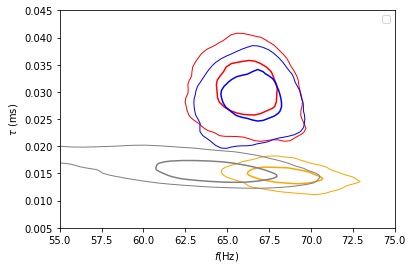

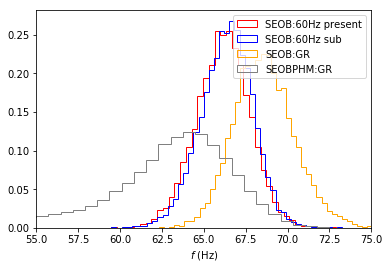

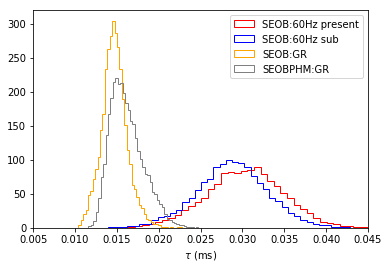

In [26]:
plt.figure()
P_xy, x_intp, y_intp, s1, s2 = P_xy_2dhist(f_seob, tau_seob, 50)
plt.contour(x_intp,y_intp,gf(P_xy), levels=(s2,s1), linewidths=(1,1.5), colors='r', labels='SEOB:60Hz present')
plt.hold(True)

P_xy, x_intp, y_intp, s1, s2 = P_xy_2dhist(f_seob_nonsens, tau_seob_nonsens, 50)
plt.contour(x_intp,y_intp,gf(P_xy), levels=(s2,s1), linewidths=(1,1.5), colors='b', labels='SEOB:60Hz sub')
plt.hold(True)

P_xy, x_intp, y_intp, s1, s2 = P_xy_2dhist(f_seob_gr, tau_seob_gr, 50)
plt.contour(x_intp,y_intp,gf(P_xy), levels=(s2,s1), linewidths=(1,1.5), colors='orange', labels='SEOB:GR')
plt.hold(True)

P_xy, x_intp, y_intp, s1, s2 = P_xy_2dhist(f_seob_gr_phm, tau_seob_gr_phm, 50)
plt.contour(x_intp,y_intp,gf(P_xy), levels=(s2,s1), linewidths=(1,1.5), colors='grey', labels='SEOB:GR')
plt.hold(True)

plt.legend(loc='best')
plt.xlabel("$f$(Hz)")
plt.ylabel(r"$\tau$ (ms)")
plt.xlim([55,75])
plt.ylim([0.005,0.045])
plt.show()

plt.figure()
plt.hist(f_seob, bins=50, histtype='step', label='SEOB:60Hz present', normed=True, color='r')
plt.hist(f_seob_nonsens, bins=50, histtype='step', label='SEOB:60Hz sub', normed=True, color='b')
plt.hist(f_seob_gr, bins=50, histtype='step', label='SEOB:GR', normed=True, color='orange')
plt.hist(f_seob_gr_phm, bins=50, histtype='step', label='SEOBPHM:GR', normed=True, color='grey')
plt.xlabel(r"$f$ (Hz)")
plt.xlim([55,75])
plt.legend(loc='best')
plt.show()

plt.figure()
plt.hist(tau_seob, bins=50, histtype='step', label='SEOB:60Hz present', normed=True, color='r')
plt.hist(tau_seob_nonsens, bins=50, histtype='step', label='SEOB:60Hz sub', normed=True, color='b')
plt.hist(tau_seob_gr, bins=50, histtype='step', label='SEOB:GR', normed=True, color='orange')
plt.hist(tau_seob_gr_phm, bins=50, histtype='step', label='SEOBPHM:GR', normed=True, color='grey')
plt.xlabel(r"$\tau$ (ms)")
plt.legend(loc='best')
plt.xlim([0.005,0.045])
plt.show()

/.auto/home/abhirup.ghosh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  # This is added back by InteractiveShellApp.init_path()
/.auto/home/abhirup.ghosh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  from ipykernel import kernelapp as app


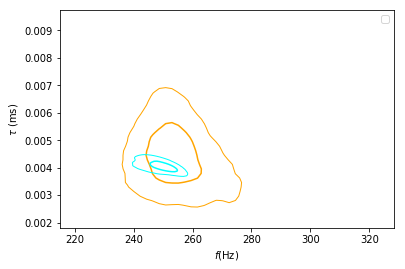

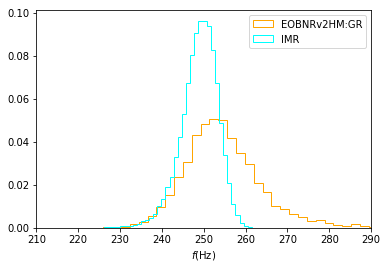

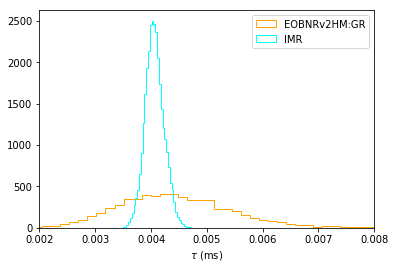

In [27]:
f_eob_gr, tau_eob_gr = np.loadtxt('../data/GW150914/Fig2/pEOB.dat', unpack=True)
samples_eob_gr = np.vstack((f_eob_gr, tau_eob_gr)).T

f_imr, tau_imr = np.loadtxt('../data/GW150914/Fig2/QNM_IMR.dat', unpack=True)
samples_imr = np.vstack((f_imr, tau_imr)).T

plt.figure()

P_xy, x_intp, y_intp, s1, s2 = P_xy_2dhist(f_eob_gr, tau_eob_gr/1000., 50)
plt.contour(x_intp,y_intp,gf(P_xy), levels=(s2,s1), linewidths=(1,1.5), colors='orange', labels='EOBNRv2HM:GR')
plt.hold(True)

P_xy, x_intp, y_intp, s1, s2 = P_xy_2dhist(f_imr, tau_imr/1000., 50)
plt.contour(x_intp,y_intp,gf(P_xy), levels=(s2,s1), linewidths=(1,1.5), colors='cyan', labels='IMR')
plt.hold(True)

plt.legend(loc='best')
plt.xlabel("$f$(Hz)")
plt.ylabel(r"$\tau$ (ms)")
#plt.xlim([210,290])
#plt.ylim([0.002, 0.008])
plt.show()


f_eob_gr, tau_eob_gr = np.loadtxt('../data/GW150914/Fig2/pEOB.dat', unpack=True)
f_imr, tau_imr = np.loadtxt('../data/GW150914/Fig2/QNM_IMR.dat', unpack=True)

plt.figure()
plt.hist(f_eob_gr, bins=50, histtype='step', label='EOBNRv2HM:GR', normed=True, color='orange')
plt.hist(f_imr, bins=50, histtype='step', label='IMR', normed=True, color='cyan')
plt.xlabel("$f$(Hz)")
plt.legend(loc='best')
plt.xlim([210,290])
plt.show()

plt.figure()
plt.hist(tau_eob_gr/1000., bins=50, histtype='step', label='EOBNRv2HM:GR', normed=True, color='orange')
plt.hist(tau_imr/1000., bins=50, histtype='step', label='IMR', normed=True, color='cyan')
plt.xlabel(r"$\tau$ (ms)")
plt.legend(loc='best')
plt.xlim([0.002, 0.008])
plt.show()

## Software Injections

### SEOBNRv4HM-pSEOBNRv4HM

In [39]:
## ModGR Run

seobhm_loc = '../runs/XLALSimInspiralChooseTDWaveformFromCache_runs/software_injections/S190521g/SEOBNRv4HM/220/cbcBayes/posterior_samples.dat'
data = np.genfromtxt(seobhm_loc, names=True, dtype=None)
m1, m2, a1z, a2z, domega, dtau = data['m1'], data['m2'], data['a1z'], data['a2z'], data['domega220'], data['dtau220']
lm = [2,2]

# create (omega, tau) GR and modGRarrays
omega_GR, tau_GR = calcqnm.get_sigmalm0SI_GR(m1, m2, a1z, a2z, lm)
freq_GR = omega_GR/(2.*np.pi)

omega_modGR, tau_modGR = calcqnm.get_sigmalm0SI_modGR(omega_GR, tau_GR, domega, dtau)
freq_modGR = omega_modGR/(2.*np.pi)

f_seobhm = freq_modGR
tau_seobhm = tau_modGR
samples_seobhm = np.vstack((f_seobhm, tau_seobhm)).T

## GR Run

seobhm_loc_gr = '../runs/XLALSimInspiralChooseTDWaveformFromCache_runs/software_injections/S190521g/SEOBNRv4HM/GR/cbcBayes/posterior_samples.dat'
data = np.genfromtxt(seobhm_loc_gr, names=True, dtype=None)
m1, m2, a1z, a2z = data['m1'], data['m2'], data['a1z'], data['a2z']
lm = [2,2]

# create (omega, tau) GR and modGRarrays
omega_GR, tau_GR = calcqnm.get_sigmalm0SI_GR(m1, m2, a1z, a2z, lm)
freq_GR = omega_GR/(2.*np.pi)

f_seobhm_gr = freq_GR
tau_seobhm_gr = tau_GR
samples_seobhm_gr = np.vstack((f_seobhm_gr, tau_seobhm_gr)).T

### SEOBNRv4PHM-pEOBNRv2HM

In [40]:
## ModGR Run

eobhm_loc = '../data/S190521g/software_injections/samples_injectionS190521g_noprec.dat'
data = np.genfromtxt(eobhm_loc, names=True, dtype=None)
m1, m2, domega, dtau = data['m1'], data['m2'], data['domega220'], data['dtau220']
a1z, a2z = np.zeros(len(m1)), np.zeros(len(m2))
lm = [2,2]

# create (omega, tau) GR and modGRarrays
omega_GR, tau_GR = calcqnm.get_sigmalm0SI_GR(m1, m2, a1z, a2z, lm)
freq_GR = omega_GR/(2.*np.pi)

omega_modGR, tau_modGR = calcqnm.get_sigmalm0SI_modGR(omega_GR, tau_GR, domega, dtau)
freq_modGR = omega_modGR/(2.*np.pi)

f_eobhm = freq_modGR
tau_eobhm = tau_modGR
samples_eobhm = np.vstack((f_eobhm, tau_eobhm)).T

## GR Run

eobhm_loc_gr = '../data/S190521g/software_injections/samples_injectionS190521g_noprecGR.dat'
data = np.genfromtxt(eobhm_loc_gr, names=True, dtype=None)
m1, m2 = data['m1'], data['m2']
a1z, a2z = np.zeros(len(m1)), np.zeros(len(m2))
lm = [2,2]

# create (omega, tau) GR and modGRarrays
omega_GR, tau_GR = calcqnm.get_sigmalm0SI_GR(m1, m2, a1z, a2z, lm)
freq_GR = omega_GR/(2.*np.pi)

f_eobhm_gr = freq_GR
tau_eobhm_gr = tau_GR
samples_eobhm_gr = np.vstack((f_eobhm_gr, tau_eobhm_gr)).T

/.auto/home/abhirup.ghosh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  after removing the cwd from sys.path.
/.auto/home/abhirup.ghosh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  
/.auto/home/abhirup.ghosh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  if sys.path[0] == '':
/.auto/home/abhirup.ghosh/.local/lib/python2.7/site-pack

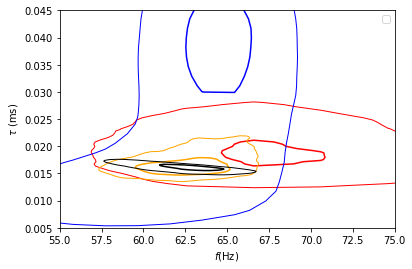

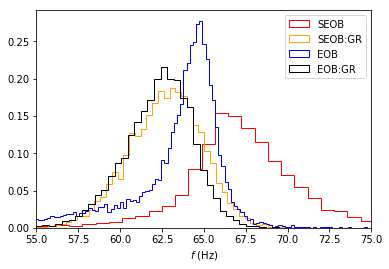

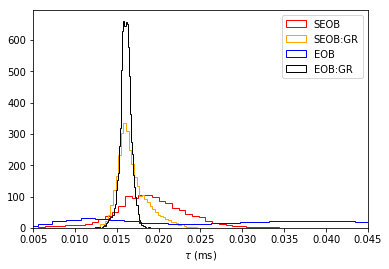

In [41]:
plt.figure()
P_xy, x_intp, y_intp, s1, s2 = P_xy_2dhist(f_seobhm, tau_seobhm, 100)
plt.contour(x_intp,y_intp,gf(P_xy), levels=(s2,s1), linewidths=(1,1.5), colors='r', labels='SEOB')
plt.hold(True)

P_xy, x_intp, y_intp, s1, s2 = P_xy_2dhist(f_seobhm_gr, tau_seobhm_gr, 50)
plt.contour(x_intp,y_intp,gf(P_xy), levels=(s2,s1), linewidths=(1,1.5), colors='orange', labels='SEOB:GR')
plt.hold(True)

P_xy, x_intp, y_intp, s1, s2 = P_xy_2dhist(f_eobhm, tau_eobhm, 50)
plt.contour(x_intp,y_intp,gf(P_xy), levels=(s2,s1), linewidths=(1,1.5), colors='b', labels='EOB')
plt.hold(True)

P_xy, x_intp, y_intp, s1, s2 = P_xy_2dhist(f_eobhm_gr, tau_eobhm_gr, 50)
plt.contour(x_intp,y_intp,gf(P_xy), levels=(s2,s1), linewidths=(1,1.5), colors='k', labels='EOB:GR')
plt.hold(True)

plt.legend(loc='best')
plt.xlabel("$f$(Hz)")
plt.ylabel(r"$\tau$ (ms)")
plt.xlim([55,75])
plt.ylim([0.005,0.045])
plt.show()

plt.figure()
plt.hist(f_seobhm, bins=500, histtype='step', label='SEOB', normed=True, color='r')
plt.hist(f_seobhm_gr, bins=50, histtype='step', label='SEOB:GR', normed=True, color='orange')
plt.hist(f_eobhm, bins=500, histtype='step', label='EOB', normed=True, color='b')
plt.hist(f_eobhm_gr, bins=50, histtype='step', label='EOB:GR', normed=True, color='k')
plt.xlabel(r"$f$ (Hz)")
plt.xlim([55,75])
plt.legend(loc='best')
plt.show()

plt.figure()
plt.hist(tau_seobhm, bins=50, histtype='step', label='SEOB', normed=True, color='r')
plt.hist(tau_seobhm_gr, bins=50, histtype='step', label='SEOB:GR', normed=True, color='orange')
plt.hist(tau_eobhm, bins=50, histtype='step', label='EOB', normed=True, color='b')
plt.hist(tau_eobhm_gr, bins=50, histtype='step', label='EOB:GR', normed=True, color='k')
plt.xlabel(r"$\tau$ (ms)")
plt.legend(loc='best')
plt.xlim([0.005,0.045])
plt.show()

### SEOBNRv4PHM-pSEOBNRv4HM

In [42]:
## ModGR run

seobphm_loc = '../runs/XLALSimInspiralChooseTDWaveformFromCache_runs/software_injections/S190521g/SEOBNRv4PHM/220/cbcBayes/posterior_samples.dat'
data = np.genfromtxt(seobphm_loc, names=True, dtype=None)
m1, m2, a1z, a2z, domega, dtau = data['m1'], data['m2'], data['a1z'], data['a2z'], data['domega220'], data['dtau220']
lm = [2,2]

# create (omega, tau) GR and modGRarrays
omega_GR, tau_GR = calcqnm.get_sigmalm0SI_GR(m1, m2, a1z, a2z, lm)
freq_GR = omega_GR/(2.*np.pi)

omega_modGR, tau_modGR = calcqnm.get_sigmalm0SI_modGR(omega_GR, tau_GR, domega, dtau)
freq_modGR = omega_modGR/(2.*np.pi)

f_seobphm = freq_modGR
tau_seobphm = tau_modGR
samples_seobphm = np.vstack((f_seobphm, tau_seobphm)).T

## GR run

seobphm_loc_gr = '../runs/XLALSimInspiralChooseTDWaveformFromCache_runs/software_injections/S190521g/SEOBNRv4PHM/GR/cbcBayes/posterior_samples.dat'
data = np.genfromtxt(seobphm_loc_gr, names=True, dtype=None)
m1, m2, a1z, a2z = data['m1'], data['m2'], data['a1z'], data['a2z']
lm = [2,2]

# create (omega, tau) GR and modGRarrays
omega_GR, tau_GR = calcqnm.get_sigmalm0SI_GR(m1, m2, a1z, a2z, lm)
freq_GR = omega_GR/(2.*np.pi)

f_seobphm_gr = freq_GR
tau_seobphm_gr = tau_GR
samples_seobphm_gr = np.vstack((f_seobphm_gr, tau_seobphm_gr)).T

### SEOBNRv4PHM-pEOBNRv2HM

In [43]:
## ModGR Run

eobphm_loc = '../data/S190521g/software_injections/samples_injectionS190521g_prec.dat'
data = np.genfromtxt(eobphm_loc, names=True, dtype=None)
m1, m2, domega, dtau = data['m1'], data['m2'], data['domega220'], data['dtau220']
a1z, a2z = np.zeros(len(m1)), np.zeros(len(m2))
lm = [2,2]

# create (omega, tau) GR and modGRarrays
omega_GR, tau_GR = calcqnm.get_sigmalm0SI_GR(m1, m2, a1z, a2z, lm)
freq_GR = omega_GR/(2.*np.pi)

omega_modGR, tau_modGR = calcqnm.get_sigmalm0SI_modGR(omega_GR, tau_GR, domega, dtau)
freq_modGR = omega_modGR/(2.*np.pi)

f_eobphm = freq_modGR
tau_eobphm = tau_modGR
samples_eobphm = np.vstack((f_eobphm, tau_eobphm)).T

## GR Run

eobphm_loc_gr = '../data/S190521g/software_injections/samples_injectionS190521g_precGR.dat'
data = np.genfromtxt(eobphm_loc_gr, names=True, dtype=None)
m1, m2 = data['m1'], data['m2']
a1z, a2z = np.zeros(len(m1)), np.zeros(len(m2))
lm = [2,2]

# create (omega, tau) GR and modGRarrays
omega_GR, tau_GR = calcqnm.get_sigmalm0SI_GR(m1, m2, a1z, a2z, lm)
freq_GR = omega_GR/(2.*np.pi)

f_eobphm_gr = freq_GR
tau_eobphm_gr = tau_GR
samples_eobphm_gr = np.vstack((f_eobphm_gr, tau_eobphm_gr)).T

/.auto/home/abhirup.ghosh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  after removing the cwd from sys.path.
/.auto/home/abhirup.ghosh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  
/.auto/home/abhirup.ghosh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  if sys.path[0] == '':
/.auto/home/abhirup.ghosh/.local/lib/python2.7/site-pack

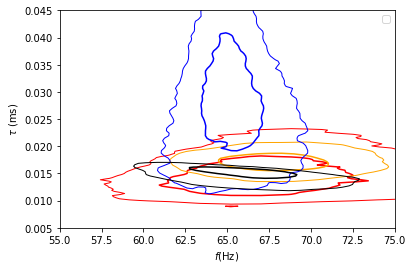

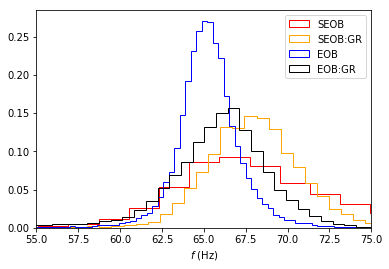

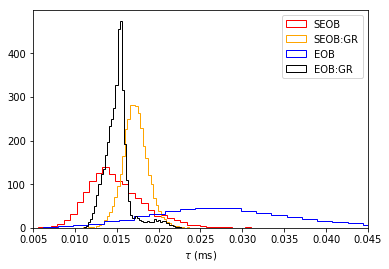

In [44]:
plt.figure()
P_xy, x_intp, y_intp, s1, s2 = P_xy_2dhist(f_seobphm, tau_seobphm, 200)
plt.contour(x_intp,y_intp,gf(P_xy), levels=(s2,s1), linewidths=(1,1.5), colors='r', labels='SEOB')
plt.hold(True)

P_xy, x_intp, y_intp, s1, s2 = P_xy_2dhist(f_seobphm_gr, tau_seobphm_gr, 50)
plt.contour(x_intp,y_intp,gf(P_xy), levels=(s2,s1), linewidths=(1,1.5), colors='orange', labels='SEOB:GR')
plt.hold(True)

P_xy, x_intp, y_intp, s1, s2 = P_xy_2dhist(f_eobphm, tau_eobphm, 200)
plt.contour(x_intp,y_intp,gf(P_xy), levels=(s2,s1), linewidths=(1,1.5), colors='b', labels='EOB')
plt.hold(True)

P_xy, x_intp, y_intp, s1, s2 = P_xy_2dhist(f_eobphm_gr, tau_eobphm_gr, 50)
plt.contour(x_intp,y_intp,gf(P_xy), levels=(s2,s1), linewidths=(1,1.5), colors='k', labels='EOB:GR')
plt.hold(True)

plt.legend(loc='best')
plt.xlabel("$f$(Hz)")
plt.ylabel(r"$\tau$ (ms)")
plt.xlim([55,75])
plt.ylim([0.005,0.045])
plt.show()

plt.figure()
plt.hist(f_seobphm, bins=200, histtype='step', label='SEOB', normed=True, color='r')
plt.hist(f_seobphm_gr, bins=50, histtype='step', label='SEOB:GR', normed=True, color='orange')
plt.hist(f_eobphm, bins=200, histtype='step', label='EOB', normed=True, color='b')
plt.hist(f_eobphm_gr, bins=50, histtype='step', label='EOB:GR', normed=True, color='k')
plt.xlabel(r"$f$ (Hz)")
plt.xlim([55,75])
plt.legend(loc='best')
plt.show()

plt.figure()
plt.hist(tau_seobphm, bins=50, histtype='step', label='SEOB', normed=True, color='r')
plt.hist(tau_seobphm_gr, bins=50, histtype='step', label='SEOB:GR', normed=True, color='orange')
plt.hist(tau_eobphm, bins=50, histtype='step', label='EOB', normed=True, color='b')
plt.hist(tau_eobphm_gr, bins=50, histtype='step', label='EOB:GR', normed=True, color='k')
plt.xlabel(r"$\tau$ (ms)")
plt.legend(loc='best')
plt.xlim([0.005,0.045])
plt.show()

#### pEOBNRv2HM: precession vs aligned

/.auto/home/abhirup.ghosh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  after removing the cwd from sys.path.
/.auto/home/abhirup.ghosh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  
/.auto/home/abhirup.ghosh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  if sys.path[0] == '':
/.auto/home/abhirup.ghosh/.local/lib/python2.7/site-pack

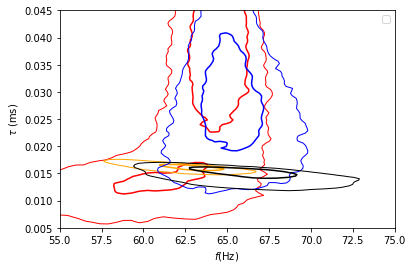

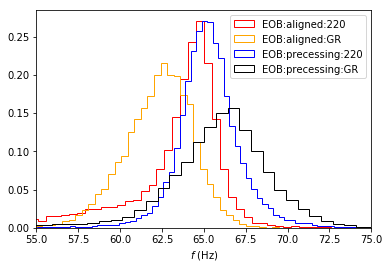

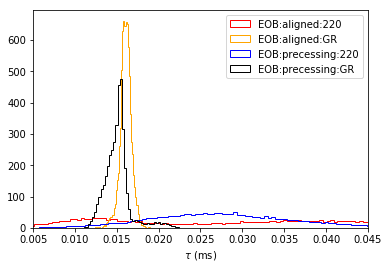

In [45]:
plt.figure()
P_xy, x_intp, y_intp, s1, s2 = P_xy_2dhist(f_eobhm, tau_eobhm, 200)
plt.contour(x_intp,y_intp,gf(P_xy), levels=(s2,s1), linewidths=(1,1.5), colors='r', labels='EOB:aligned:220')
plt.hold(True)

P_xy, x_intp, y_intp, s1, s2 = P_xy_2dhist(f_eobhm_gr, tau_eobhm_gr, 50)
plt.contour(x_intp,y_intp,gf(P_xy), levels=(s2,s1), linewidths=(1,1.5), colors='orange', labels='EOB:aligned:GR')
plt.hold(True)

P_xy, x_intp, y_intp, s1, s2 = P_xy_2dhist(f_eobphm, tau_eobphm, 200)
plt.contour(x_intp,y_intp,gf(P_xy), levels=(s2,s1), linewidths=(1,1.5), colors='b', labels='EOB:precessing:220')
plt.hold(True)

P_xy, x_intp, y_intp, s1, s2 = P_xy_2dhist(f_eobphm_gr, tau_eobphm_gr, 50)
plt.contour(x_intp,y_intp,gf(P_xy), levels=(s2,s1), linewidths=(1,1.5), colors='k', labels='EOB:precessing:GR')
plt.hold(True)

plt.legend(loc='best')
plt.xlabel("$f$(Hz)")
plt.ylabel(r"$\tau$ (ms)")
plt.xlim([55,75])
plt.ylim([0.005,0.045])
plt.show()

plt.figure()
plt.hist(f_eobhm, bins=200, histtype='step', label='EOB:aligned:220', normed=True, color='r')
plt.hist(f_eobhm_gr, bins=50, histtype='step', label='EOB:aligned:GR', normed=True, color='orange')
plt.hist(f_eobphm, bins=200, histtype='step', label='EOB:precessing:220', normed=True, color='b')
plt.hist(f_eobphm_gr, bins=50, histtype='step', label='EOB:precessing:GR', normed=True, color='k')
plt.xlabel(r"$f$ (Hz)")
plt.xlim([55,75])
plt.legend(loc='best')
plt.show()

plt.figure()
plt.hist(tau_eobhm, bins=200, histtype='step', label='EOB:aligned:220', normed=True, color='r')
plt.hist(tau_eobhm_gr, bins=50, histtype='step', label='EOB:aligned:GR', normed=True, color='orange')
plt.hist(tau_eobphm, bins=200, histtype='step', label='EOB:precessing:220', normed=True, color='b')
plt.hist(tau_eobphm_gr, bins=50, histtype='step', label='EOB:precessing:GR', normed=True, color='k')
plt.xlabel(r"$\tau$ (ms)")
plt.legend(loc='best')
plt.xlim([0.005,0.045])
plt.show()

#### pSEOBNRv4HM: precession vs aligned

/.auto/home/abhirup.ghosh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  after removing the cwd from sys.path.
/.auto/home/abhirup.ghosh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  
/.auto/home/abhirup.ghosh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  if sys.path[0] == '':
/.auto/home/abhirup.ghosh/.local/lib/python2.7/site-pack

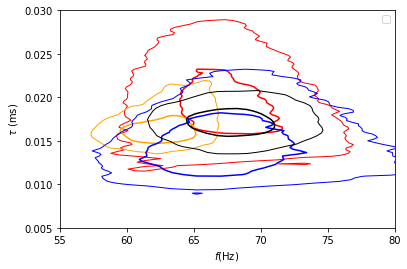

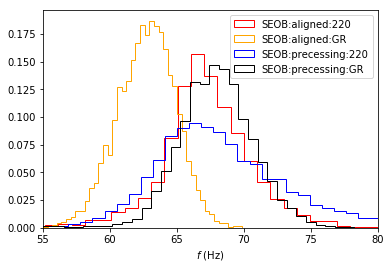

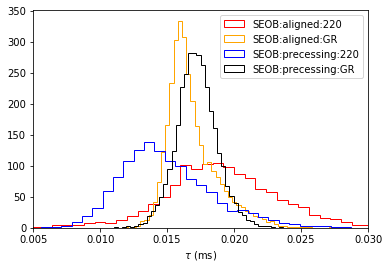

In [46]:
plt.figure()
P_xy, x_intp, y_intp, s1, s2 = P_xy_2dhist(f_seobhm, tau_seobhm, 200)
plt.contour(x_intp,y_intp,gf(P_xy), levels=(s2,s1), linewidths=(1,1.5), colors='r', labels='SEOB:aligned:220')
plt.hold(True)

P_xy, x_intp, y_intp, s1, s2 = P_xy_2dhist(f_seobhm_gr, tau_seobhm_gr, 50)
plt.contour(x_intp,y_intp,gf(P_xy), levels=(s2,s1), linewidths=(1,1.5), colors='orange', labels='SEOB:aligned:GR')
plt.hold(True)

P_xy, x_intp, y_intp, s1, s2 = P_xy_2dhist(f_seobphm, tau_seobphm, 200)
plt.contour(x_intp,y_intp,gf(P_xy), levels=(s2,s1), linewidths=(1,1.5), colors='b', labels='SEOB:precessing:220')
plt.hold(True)

P_xy, x_intp, y_intp, s1, s2 = P_xy_2dhist(f_seobphm_gr, tau_seobphm_gr, 50)
plt.contour(x_intp,y_intp,gf(P_xy), levels=(s2,s1), linewidths=(1,1.5), colors='k', labels='SEOB:precessing:GR')
plt.hold(True)

plt.legend(loc='best')
plt.xlabel("$f$(Hz)")
plt.ylabel(r"$\tau$ (ms)")
plt.xlim([55,80])
plt.ylim([0.005,0.03])
plt.show()

plt.figure()
plt.hist(f_seobhm, bins=400, histtype='step', label='SEOB:aligned:220', normed=True, color='r')
plt.hist(f_seobhm_gr, bins=50, histtype='step', label='SEOB:aligned:GR', normed=True, color='orange')
plt.hist(f_seobphm, bins=400, histtype='step', label='SEOB:precessing:220', normed=True, color='b')
plt.hist(f_seobphm_gr, bins=50, histtype='step', label='SEOB:precessing:GR', normed=True, color='k')
plt.xlabel(r"$f$ (Hz)")
plt.xlim([55,80])
plt.legend(loc='best')
plt.show()

plt.figure()
plt.hist(tau_seobhm, bins=50, histtype='step', label='SEOB:aligned:220', normed=True, color='r')
plt.hist(tau_seobhm_gr, bins=50, histtype='step', label='SEOB:aligned:GR', normed=True, color='orange')
plt.hist(tau_seobphm, bins=50, histtype='step', label='SEOB:precessing:220', normed=True, color='b')
plt.hist(tau_seobphm_gr, bins=50, histtype='step', label='SEOB:precessing:GR', normed=True, color='k')
plt.xlabel(r"$\tau$ (ms)")
plt.legend(loc='best')
plt.xlim([0.005,0.03])
plt.show()